Importing libraries and setting up the working env.
---
---

In [2]:
import os
from io import StringIO
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import datetime as dt
from cycler import cycler
from scipy.ndimage import gaussian_filter1d

In [3]:
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['grid.linestyle'] = '--'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [4]:
figure_dir = 'figures'
tables_dir = 'tables'

colors = {
        'blue': 'blue',
        'red': 'red',
        'green': '#2ca02c',
        'orange': '#ff7f0e',
        'purple': '#9467bd',
        'cyan': '#17becf',
        'brown': '#8c564b',
        'gray': '#7f7f7f',
        'pink': '#e377c2',
        'olive': '#bcbd22',
    }

# Create a list of colors from the dictionary
color_list = list(colors.values())

# Set the color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=color_list)

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
if not os.path.exists(tables_dir):
    os.makedirs(tables_dir)
current_date = dt.datetime.now().strftime("%Y.%m.%d")
# Set font size and family 
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = "Times New Roman"
ills_path = "./illustrations/"
os.chdir(os.getcwd()) # Chang the working directory to the current one
print(f"Current date: {current_date}")

Current date: 2025.02.16


Processing the data
---
---

In [5]:
import logsParser

In [6]:
os.chdir(os.getcwd())  # Change the working directory to the current one

# Process slice data
slice_data_path = os.path.join(tables_dir, "2025.02.10 - Ecolibry_slice_distr.csv")
slice_data = logsParser.process_slice_data(slice_data_path)
slice_data.tail()
#slice_data.to_csv(os.path.join(tables_dir, f"{current_date}_Ecolibry_SD.csv"))

,height,tss,part,nss,ss
1496,44.88,501.626,501.626,0.0,0.0
1497,44.91,500.740,500.740,0.0,0.0
1498,44.94,499.851,499.851,0.0,0.0
1499,44.97,498.962,498.962,0.0,0.0
1500,45.00,0.000,0.000,0.0,0.0


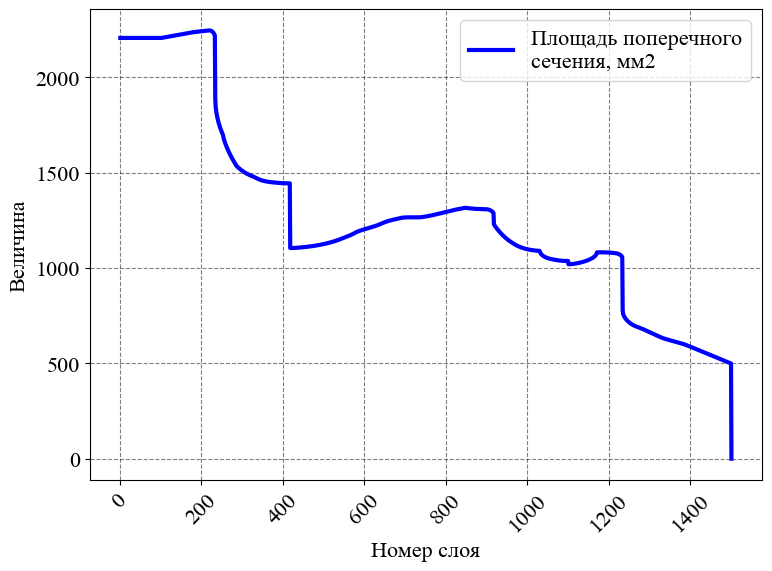

In [7]:
plt.plot(slice_data.index+1, slice_data['tss'], label="Площадь поперечного\nсечения, мм2", linewidth=3)
plt.grid(which='both', color='k', alpha=0.5, linestyle='--')
plt.xlabel("Номер слоя")
plt.ylabel("Величина")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, f"{current_date}_Ecolibry_tss.png"), dpi=300)
plt.show()

### "Fixed number" Sampling

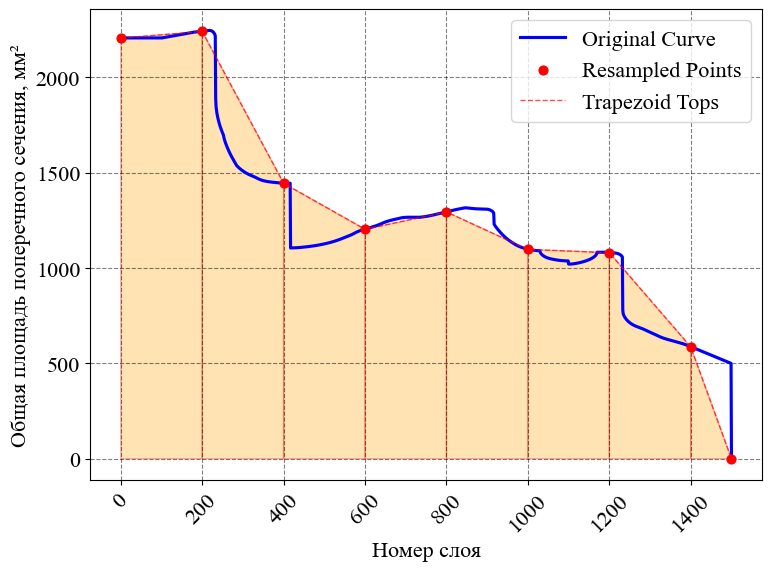

In [8]:
# Extract the height (x) and tss (y) columns
x = slice_data.index
y = slice_data['tss'].values+1

# Resample slice_data (every 50th point for visualization)
resample_step = 200
resampled = slice_data.iloc[::resample_step].copy()

# Ensure we include the last point
if resampled.index[-1] != slice_data.index[-1]:
    resampled = pd.concat([resampled, slice_data.iloc[[-1]]])

x_res = resampled['height'].index
y_res = resampled['tss'].values


plt.plot(x, y, color='blue', linewidth=2.25, label='Original Curve')

# Plot trapezoidal approximation
for i in range(len(x_res)-1):
    # Create trapezoid vertices
    vertices = [
        (x_res[i], 0),
        (x_res[i], y_res[i]),
        (x_res[i+1], y_res[i+1]),
        (x_res[i+1], 0)
    ]
    
    # Plot trapezoid
    plt.fill(*zip(*vertices), alpha=0.3, edgecolor='red', linewidth=1, facecolor='orange')

# Plot resampled points
plt.scatter(x_res, y_res, color='red', s=40, zorder=3, label='Resampled Points')
plt.plot(x_res, y_res, 'r--', linewidth=1, alpha=0.7, label='Trapezoid Tops')

# Formatting
plt.grid(which='both', color='k', alpha=0.5, linestyle='--')
plt.xlabel("Номер слоя")
plt.ylabel("Общая площадь поперечного сечения, мм²")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()

# Calculate and display area
area = np.trapz(y, x)
#plt.title(f"Area under curve: {area:.2f} mm²", pad=20)

plt.show()

### Error-Based Sampling

In [9]:
import spec_func as sf

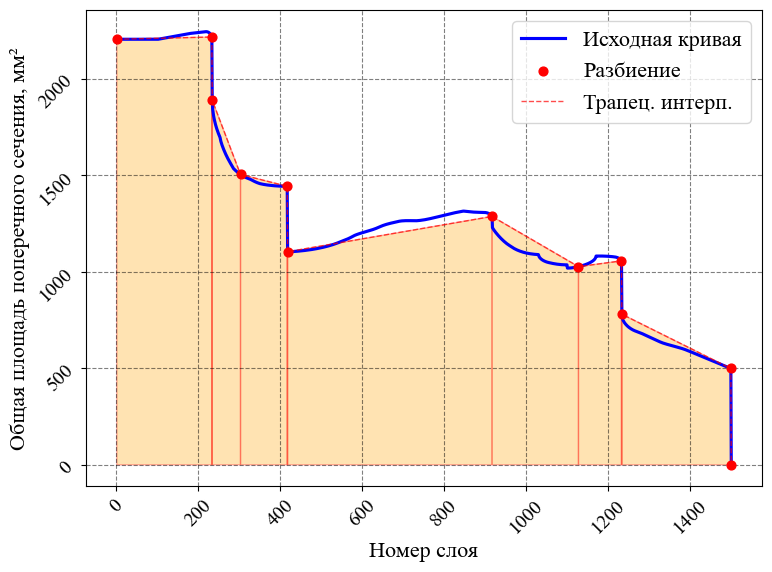

In [10]:
# Original slice_data
x = slice_data.index+1
y = slice_data['tss'].values

# Set the maximum allowed error
max_error = 100  # Adjust this value as needed


# Resample the slice_data based on the maximum error
x_res, y_res = sf.resample_based_on_error(x, y, max_error)

# Plot original slice_data
plt.plot(x, y, color='blue', linewidth=2.25, label='Исходная кривая')

# Plot trapezoidal approximation
for i in range(len(x_res) - 1):
    # Create trapezoid vertices
    vertices = [
        (x_res[i], 0),
        (x_res[i], y_res[i]),
        (x_res[i + 1], y_res[i + 1]),
        (x_res[i + 1], 0)
    ]
    
    # Plot trapezoid
    plt.fill(*zip(*vertices), alpha=0.3, edgecolor='red', linewidth=1, facecolor='orange')

# Plot resampled points
plt.scatter(x_res, y_res, color='red', s=40, zorder=3, label='Разбиение')
plt.plot(x_res, y_res, 'r--', linewidth=1, alpha=0.7, label='Трапец. интерп.')

# Formatting
plt.grid(which='both', color='k', alpha=0.5, linestyle='--')
plt.xlabel("Номер слоя")
plt.ylabel("Общая площадь поперечного сечения, мм²")
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=45, fontsize=14)

plt.legend(loc='upper right')
plt.tight_layout()

# Calculate and display area
area = np.trapz(y, x)
# plt.title(f"Area under curve: {area:.2f} mm² | Max Error: {max_error}", pad=20)

plt.show()

In [11]:
# Измерь время изготовления слоёв пилотным лазером на следующих слоях:
print(x_res)

Index([1, 233, 234, 303, 417, 418, 917, 1128, 1233, 1234, 1500, 1501], dtype='int64')


In [12]:
mes_time = np.array([30, 30.07, 19.27, 18.97, 20.04, 17.84, 12.59, 10.00]) # ввод времени печати слоёв в секундах
if len(mes_time) == len(x_res):
    print(f"Время печати: {np.trapz(mes_time, x_res) / 3600:.2f} ч")
else:
    print("Длина массивов различна!")

Длина массивов различна!


In [13]:
# Время начала печати проекта 2025.02.10 - Ecolibry --- 14:40 2025.02.13

In [14]:
# Selected points and measured times
sel_x = np.array([0, 226, 416, 420, 917, 1232, 1250, 1500])+1  # Selected points
mes_time = np.array([30, 30.07, 19.27, 18.97, 20.04, 17.84, 12.59, 10.00]) + 10  # Layer times in seconds

# Print total print time
total_print_time = np.trapz(mes_time, sel_x) / 3600  # Convert to hours
print(f"Общее время печати: {total_print_time:.2f} ч")

Общее время печати: 12.59 ч


### Comarasion of estimated print time with log data

In [15]:
logs = logsParser.read_and_clean_log(os.path.join(tables_dir, "13.02.2025_burn.log"))
logs = logsParser.process_logs(logs, reference_date=pd.to_datetime('2025-02-13'))
logs["time_dif"] = logs["Time"].diff().dt.total_seconds() # layer manufacturing time (in sec)
logs["time_dif"] = logs[logs["time_dif"] < 100]["time_dif"].rolling(10, center=True).mean()
# Compute cumulative sum of log data
logs["cumulative_time"] = logs["time_dif"].cumsum()
cumulative_integral_at_sel_x = np.array([np.trapz(mes_time[:i+1], sel_x[:i+1]) for i in range(len(sel_x))])


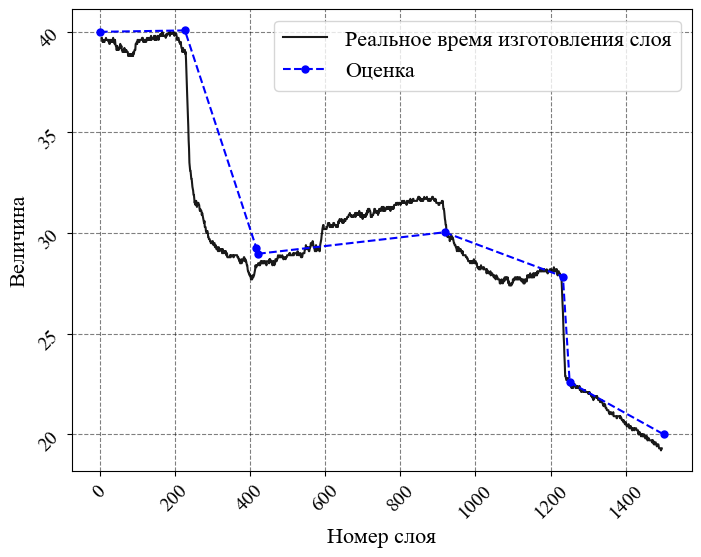

In [16]:
plt.plot(logs["time_dif"].index, logs["time_dif"], label="Реальное время изготовления слоя",\
         linestyle="-", markersize=10, color="black", alpha=0.9)
plt.plot(sel_x, mes_time, linestyle="--", marker=".", markersize=10, label="Оценка")

plt.grid(which='both', color='k', alpha=0.5, linestyle='--')
plt.xlabel("Номер слоя")
plt.ylabel("Величина")
plt.legend(loc='upper right')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=45, fontsize=14)
plt.show()

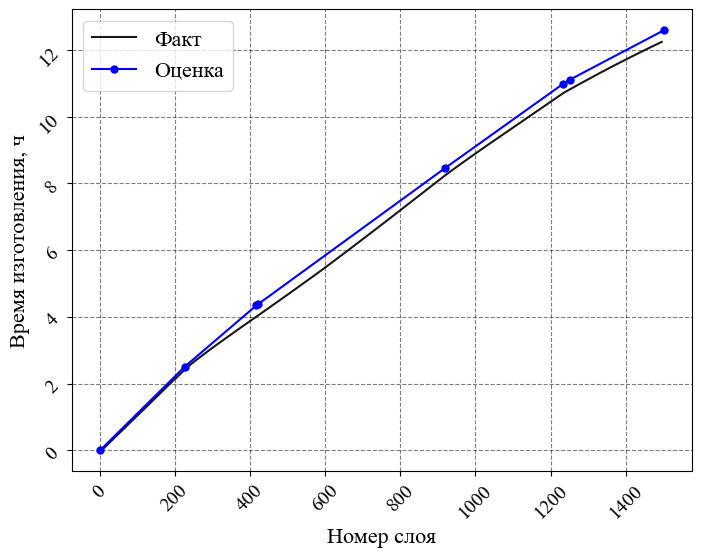

In [28]:
# Plot comparison
plt.plot(logs["time_dif"].index, logs["cumulative_time"]/3600, label="Факт",\
         linestyle="-", color="black", alpha=0.9)
plt.plot(sel_x, cumulative_integral_at_sel_x/3600, linestyle="-", marker=".", markersize=10, label="Оценка")
plt.grid(which='both', color='k', alpha=0.5, linestyle='--')
plt.xlabel("Номер слоя")
plt.ylabel("Время изготовления, ч")
plt.legend(loc='best')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=45, fontsize=14)
plt.show()